#Import

In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import directed_hausdorff
from skimage import io
import matplotlib.pyplot as plt
from random import shuffle
import nibabel as nib
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import random
import pandas as pd

# Data Preparing

In [ ]:
def read_file(root_path):
    """
    Read and preprocess medical image files from the specified root path.

    Args:
    - root_path (str): The root directory.

    Returns:
    - datas (np.ndarray): Processed image data with shape (num_samples, 1, 256, 256).
    - labels (np.ndarray): Processed label data with shape (num_samples, 4, 256, 256).
    """
    patients = sorted(os.listdir(root_path))
    datas = np.zeros((2858, 1, 256, 256))
    labels = np.zeros((2858, 4, 256, 256))
    idx = 0

    for patient_index in patients:
        patient_path = os.path.join(root_path, patient_index)
        files = os.listdir(patient_path)
        filtered_files = [file for file in files if "_gt.nii.gz" in file]
        filtered_files = [file.replace("_gt.nii.gz", "") for file in filtered_files]
        for i in range(2):
            image = nib.load(os.path.join(patient_path, filtered_files[0] + ".nii.gz"))
            image = image.get_fdata()
            mask = nib.load(os.path.join(patient_path, filtered_files[0] + "_gt.nii.gz"))
            mask = mask.get_fdata()
            image = image.astype(np.float32)
            image = np.divide((image - np.mean(image)), np.std(image))
            slice_num = image.shape[2]
            image = resize(image, (256, 256, slice_num), mode="constant", cval=0)
            mask = resize(mask, (256, 256, slice_num), mode="constant", cval=0)
            mask_new = np.zeros((4, 256, 256, slice_num))
            for j in range(4):
                mask_new[j, :, :, :] = mask[:, :, :] == j
            for j in range(slice_num):
                datas[idx, 0, :, :] = image[:, :, j]
                labels[idx, :, :, :] = mask_new[:, :, :, j]
                idx += 1
    return datas, labels

In [ ]:
class ImageDataset(Dataset):
    """
    Custom Dataset.

    Args:
    - data (list): List of input images.
    - labels (list): List of corresponding segmentation masks.
    - transform (callable, optional): Transform that made to input image and its corresponding mask.

    Returns:
    - sample (dict): A dictionary containing the transformed input image ('data') and
      its corresponding transformed segmentation mask ('label').
    """
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = torch.tensor(self.data[index], dtype=torch.float32)
        mask = torch.tensor(self.labels[index], dtype=torch.float32)
        if self.transform:
            cat_image = torch.cat((img, mask), 0)
            cat_image = self.transform(cat_image)
            img = cat_image[0, :, :]
            mask = cat_image[1:, :, :]
            img = torch.reshape(img, (1, 256, 256))
            mask = torch.reshape(mask, (4, 256, 256))
        sample = {'data': img, 'label': mask}

        return sample

In [ ]:
def reconstruct(label):
    """
    Reconstruct a segmentation mask from the label.

    Args:
    - label (list or array-like): List or array containing binary masks for each class.

    Returns:
    - mask (numpy.ndarray): Reconstructed segmentation mask where each pixel is assigned the class index.
    """
    if label.dim() == 3:
        mask = torch.argmax(label, 0)
    else:
        mask = torch.argmax(label, 1)[0]
    return mask

# Data Augmentation

In [ ]:
# Applied augmentations
img_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation((-10, 10))
])

# Model Construction

In [ ]:
def conv_block(dim_in,
               dim_out,
               kernel_size=3,
               stride=1,
               padding=1,
               bias=True):
    """
    Functions for adding the convolution layers.

    Args:
    - dim_in (int): Number of input channels.
    - dim_out (int): Number of output channels.
    - kernel_size (int, optional): Size of the convolutional kernel (default is `3`).
    - stride (int, optional): Stride of the convolution (default is `1`).
    - padding (int, optional): Padding added to the input (default is `1`).
    - bias (bool, optional): The bias. Default is True.

    Returns:
    - (nn.Sequential): the convolutional block
    """
    return nn.Sequential(
        nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(dim_out),
        nn.LeakyReLU(0.1),
        nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(dim_out),
        nn.LeakyReLU(0.1)
    )


def upsample(ch_coarse, ch_fine,
             kernel_size=4,
             stride=2,
             padding=1):
    """
    Functions for adding the upsampling layers.

    Args:
    - ch_coarse (int): Number of input channels
    - ch_fine (int): Number of output channels
    - kernel_size (int, optional): Size of the convolutional kernel (default is `4`).
    - stride (int, optional): Stride of the convolution (default is `2`).
    - padding (int, optional): Padding added to the input (default is `1`).

    Returns:
    - (nn.Sequential): the upsampling module
    """
    return nn.Sequential(
        nn.ConvTranspose2d(ch_coarse, ch_fine, kernel_size, stride, padding, bias=False),
        nn.ReLU())

In [ ]:
class ConvDeconv(nn.Module):
    """
    The Convolution-Deconvolution model.
    """

    def __init__(self, n_in, n_out):
        """
        Args:
        - n_in (int): Number of channels the image has.
        - n_out (int): Number of classes.
        """
        super(ConvDeconv, self).__init__()
        # Downgrade stages
        self.conv1 = conv_block(n_in, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)
        # Upgrade stages
        self.conv4m = conv_block(1024, 512)
        self.conv3m = conv_block(512, 256)
        self.conv2m = conv_block(256, 128)
        self.conv1m = conv_block(128, 64)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample54 = upsample(1024, 1024)
        self.upsample43 = upsample(512, 512)
        self.upsample32 = upsample(256, 256)
        self.upsample21 = upsample(128, 128)
        self.convfinal = nn.Conv2d(64, n_out, kernel_size=1)
        self.actfinal = nn.Softmax(dim=1)

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        """
        Forward pass.

        Args:
        - x (tensor): The data batch.

        Returns:
        - output (tensor): Result of forward pass.
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))
        conv5_out = self.conv5(self.max_pool(conv4_out))

        conv5m_out_ = self.upsample54(conv5_out)
        conv4m_out = self.conv4m(conv5m_out_)
        conv4m_out_ = self.upsample43(conv4m_out)
        conv3m_out = self.conv3m(conv4m_out_)
        conv3m_out_ = self.upsample32(conv3m_out)
        conv2m_out = self.conv2m(conv3m_out_)
        conv2m_out_ = self.upsample21(conv2m_out)
        conv1m_out = self.conv1m(conv2m_out_)

        convfinal_out = self.convfinal(conv1m_out)
        output = self.actfinal(convfinal_out)
        return output

In [ ]:
class UNET(nn.Module):
    """
    The U-Net model.
    """

    def __init__(self, n_in, n_out):
        """
        Args:
        - n_in (int): Number of channels the image has.
        - n_out (int): Number of classes.
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = conv_block(n_in, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)
        # Upgrade stages
        self.conv4m = conv_block(1024, 512)
        self.conv3m = conv_block(512, 256)
        self.conv2m = conv_block(256, 128)
        self.conv1m = conv_block(128, 64)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample54 = upsample(1024, 512)
        self.upsample43 = upsample(512, 256)
        self.upsample32 = upsample(256, 128)
        self.upsample21 = upsample(128, 64)
        self.convfinal = nn.Conv2d(64, n_out, kernel_size=1)
        self.actfinal = nn.Softmax(dim=1)

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        """
        Forward pass.

        Args:
        - x (tensor): The data batch.

        Returns:
        - output (tensor): Result of forward pass.
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))
        conv5_out = self.conv5(self.max_pool(conv4_out))

        conv5m_out_ = torch.cat((self.upsample54(conv5_out), conv4_out), 1)
        conv4m_out = self.conv4m(conv5m_out_)
        conv4m_out_ = torch.cat((self.upsample43(conv4m_out), conv3_out), 1)
        conv3m_out = self.conv3m(conv4m_out_)
        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out = self.conv2m(conv3m_out_)
        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out = self.conv1m(conv2m_out_)

        convfinal_out = self.convfinal(conv1m_out)
        output = self.actfinal(convfinal_out)
        return output

In [ ]:
class GridNet(nn.Module):
    """
    The Grid Net model.
    """

    def __init__(self, n_in, n_out):
        """
        Args:
        - n_in (int): Number of channels the image has.
        - n_out (int): Number of classes.
        """
        super(GridNet, self).__init__()
        # Downgrade stages
        self.conv1 = conv_block(n_in, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)

        # Upgrade stages with added convolution layers at skip connections
        self.conv4m = conv_block(1024, 512)
        self.conv3m = conv_block(512, 256)
        self.conv2m = conv_block(256, 128)
        self.conv1m = conv_block(128, 64)

        # Maxpool
        self.max_pool = nn.MaxPool2d(2)

        # Upsample layers
        self.upsample54 = upsample(1024, 1024 - 512, 2, 2, 0)
        self.upsample43 = upsample(512, 512 - 256, 2, 2, 0)
        self.upsample32 = upsample(256, 256 - 128, 2, 2, 0)
        self.upsample21 = upsample(128, 128 - 64, 2, 2, 0)

        # Convolution layers added at skip connections
        self.conv_skip54 = conv_block(512, 512)
        self.conv_skip43 = conv_block(256, 256)
        self.conv_skip32 = conv_block(128, 128)
        self.conv_skip21 = conv_block(64, 64)

        self.convfinal = nn.Conv2d(64, n_out, kernel_size=1)
        self.actfinal = nn.Softmax(dim=1)

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        """
        Forward pass.
        
        Args:
        - x (tensor): The data batch

        Returns:
        - output (tensor): Result of forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))
        conv5_out = self.conv5(self.max_pool(conv4_out))
        conv5m_out_ = torch.cat((self.upsample54(conv5_out), self.conv_skip54(conv4_out)), 1)
        conv4m_out = self.conv4m(conv5m_out_)
        conv4m_out_ = torch.cat((self.upsample43(conv4m_out), self.conv_skip43(conv3_out)), 1)
        conv3m_out = self.conv3m(conv4m_out_)
        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), self.conv_skip32(conv2_out)), 1)
        conv2m_out = self.conv2m(conv3m_out_)
        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), self.conv_skip21(conv1_out)), 1)
        conv1m_out = self.conv1m(conv2m_out_)

        convfinal_out = self.convfinal(conv1m_out)
        output = self.actfinal(convfinal_out)
        return output

#Training, Tuning

In [ ]:
## Mount Google Drive Data
try:
    from google.colab import drive

    drive.mount("/content/drive")
except:
    print("Mounting Failed.")

Mounted at /content/drive


In [ ]:
# Read files and split sets
try:
    root_path = "/content/drive/MyDrive/MLDL/project"
    datas, labels = read_file(os.path.join(root_path, "data"))
except:
    root_path = "/content/drive/MyDrive/Colab Notebooks/EN.601.682/Project"
    datas, labels = read_file(os.path.join(root_path, "data"))
# Training: 80%
# Validation: 10%
# Testing: 10%
train_data, temp_data, train_label, temp_label = train_test_split(datas, labels, test_size=0.2, random_state=42)
val_data, test_data, val_label, test_label = train_test_split(temp_data, temp_label, test_size=0.5, random_state=42)
del datas
del labels

In [ ]:
# Dataset & dataloader
train_dataset = ImageDataset(train_data, train_label, transform=img_transform)
val_dataset = ImageDataset(val_data, val_label)
test_dataset = ImageDataset(test_data, test_label)

In [ ]:
# Sample visualization
test_sample = test_dataset[0]
test_data = test_sample['data']
test_label = test_sample['label']
plt.subplot(1, 2, 1)
plt.imshow(test_data[0], cmap='gray')
plt.show()
plt.subplot(1, 2, 2)
plt.imshow(reconstruct(test_label), cmap='gray')
plt.show()

In [ ]:
# Input output initialization
n_channels = 1
n_classes = 4
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize loss function
loss_f = nn.BCELoss()
# Batch Size
train_batch_size = 10
validation_batch_size = 10
test_batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=validation_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [ ]:
def train(model_path, model, loss_f, optimizer, scheduler, num_epochs,
          device=device,
          train_dataloader=train_dataloader,
          validation_dataloader=val_dataloader):
    """
    Train the specified model.

    Args:
    - model_path (str): The file path to save the trained model.
    - model (nn.Module): The model to train.
    - loss_f (nn.Module): The loss function used for training.
    - optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
    - scheduler (torch.optim.lr_scheduler): The learning rate scheduler.
    - num_epochs (int): The number of training epochs.
    - device (torch.device, optional): The device on which to perform training (default is `device`).
    - train_dataloader (torch.utils.data.DataLoader, optional): The DataLoader for training data (default is `train_dataloader`).
    - validation_dataloader (torch.utils.data.DataLoader, optional): The DataLoader for validation data (default is `val_dataloader`).

    Returns:
    - loss_train (list): A list containing the training loss for each epoch.
    - loss_val (list): A list containing the validation loss for each epoch.
    - best_model (dict): A dictionary containing the parameters of the best model.
    """
    model.to(device)
    loss_train = []
    loss_val = []
    # Initialize early stopping
    patience = 10
    epoch_worse = 0
    best_val_loss = float("Inf")
    best_model = None

    print("Start Training...")
    for epoch in range(num_epochs):
        # Training
        print("\nEPOCH " + str(epoch + 1) + " of " + str(num_epochs) + "\n")
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            train_image = batch["data"]
            train_target = batch["label"]
            train_image = train_image.to(device)
            train_target = train_target.to(device)
            optimizer.zero_grad()
            train_pred = model(train_image)
            batch_loss = loss_f(train_pred, train_target)
            train_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
        loss_train.append(train_loss / len(train_dataloader))
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in validation_dataloader:
                val_image = batch["data"]
                val_target = batch["label"]
                val_image = val_image.to(device)
                val_target = val_target.to(device)
                val_pred = model(val_image)
                batch_loss = loss_f(val_pred, val_target)
                val_loss += batch_loss.item()
        loss_val.append(val_loss / len(validation_dataloader))

        # Update learning rate
        scheduler.step()

        # Progress check
        if epoch % 1 == 0:
            print(f"training loss: {loss_train[-1]},"
                  f"\nvalidation loss: {loss_val[-1]}")

        # Early stop when validation loss stop decreasing
        if loss_val[-1] < best_val_loss:
            best_val_loss = loss_val[-1]
            epoch_worse = 0
            best_model = model.state_dict()
        else:
            epoch_worse += 1
        if epoch_worse >= patience:
            print(f"Early stop due to validation loss not decrease for {epoch_worse} epochs")
            break
    torch.save(best_model, model_path)
    return loss_train, loss_val, best_model

In [ ]:
def loss_curve(loss_train, loss_val, title):
    plt.figure()
    plt.plot(range(len(loss_train)), loss_train, label="Training BCE Loss")
    plt.plot(range(len(loss_val)), loss_val, label="Validation BCE Loss")
    plt.title(title + " BCE Loss vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.legend()
    plt.show()

Start Training...

EPOCH 1 of 200

training loss: 0.0968765834240674,
validation loss: 0.07103986498610727

EPOCH 2 of 200

training loss: 0.05903320863647753,
validation loss: 0.040329889362228324

EPOCH 3 of 200

training loss: 0.04173095430772117,
validation loss: 0.025883090072150887

EPOCH 4 of 200

training loss: 0.03503564642701607,
validation loss: 0.01696243936774032

EPOCH 5 of 200

training loss: 0.029990551114798113,
validation loss: 0.015036720557716387

EPOCH 6 of 200

training loss: 0.026409992533349573,
validation loss: 0.011467543157652534

EPOCH 7 of 200

training loss: 0.023669437106747553,
validation loss: 0.014022166744388383

EPOCH 8 of 200

training loss: 0.02222625617604849,
validation loss: 0.011497214966421497

EPOCH 9 of 200

training loss: 0.022038986715264455,
validation loss: 0.00892976168864246

EPOCH 10 of 200

training loss: 0.02032947464638662,
validation loss: 0.008989719144100773

EPOCH 11 of 200

training loss: 0.019151270751511948,
validation loss:

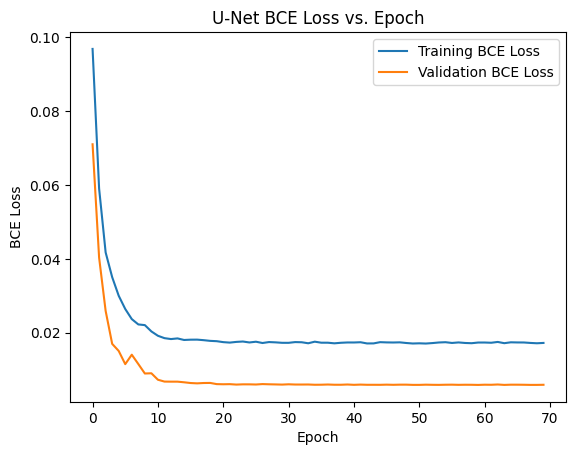

In [ ]:
# U-Net
unet = UNET(n_channels, n_classes)
## Epochs
num_epochs = 200
## Initialize Optimizer and Learning Rate Scheduler
learning_rate = 0.001
optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
## Training and tuning
loss_train_unet, loss_val_unet, best_unet = train(os.path.join(root_path, "unet.pth"), unet, loss_f, optimizer,
                                                  scheduler, num_epochs)
loss_curve(loss_train_unet, loss_val_unet, "U-Net")

Start Training...

EPOCH 1 of 200

training loss: 0.10539934255475561,
validation loss: 0.05662003673356155

EPOCH 2 of 200

training loss: 0.05698403171121293,
validation loss: 0.03875549047671516

EPOCH 3 of 200

training loss: 0.04174716934138771,
validation loss: 0.024126472144291318

EPOCH 4 of 200

training loss: 0.03650983722319249,
validation loss: 0.019738376493854768

EPOCH 5 of 200

training loss: 0.03148280780388278,
validation loss: 0.017038343442154342

EPOCH 6 of 200

training loss: 0.028183253099694522,
validation loss: 0.018816847900121378

EPOCH 7 of 200

training loss: 0.026826716333172206,
validation loss: 0.013483451165515801

EPOCH 8 of 200

training loss: 0.02491926026071003,
validation loss: 0.011583302137923652

EPOCH 9 of 200

training loss: 0.024174299091100693,
validation loss: 0.010605444521482649

EPOCH 10 of 200

training loss: 0.023255631880728957,
validation loss: 0.0101145566119973

EPOCH 11 of 200

training loss: 0.020597906433468822,
validation loss:

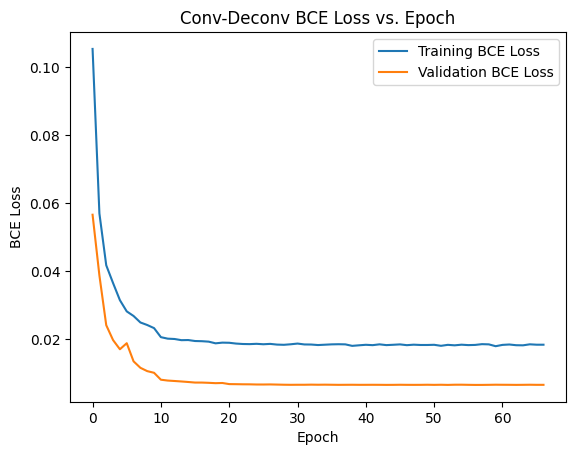

In [ ]:
# Conv-Deconv
conv_deconv = ConvDeconv(n_channels, n_classes)
## Epochs
num_epochs = 200
## Initialize Optimizer and Learning Rate Scheduler
learning_rate = 0.001
optimizer = torch.optim.Adam(conv_deconv.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
## Training and tuning
loss_train_cd, loss_val_cd, best_cd = train(os.path.join(root_path, "convdeconv.pth"), conv_deconv, loss_f, optimizer,
                                            scheduler, num_epochs)
loss_curve(loss_train_cd, loss_val_cd, "Conv-Deconv")

Start Training...

EPOCH 1 of 200

training loss: 0.14707936388826787,
validation loss: 0.057443598863379706

EPOCH 2 of 200

training loss: 0.057644497001275226,
validation loss: 0.07125046810713308

EPOCH 3 of 200

training loss: 0.04054805046703878,
validation loss: 0.021710583426315207

EPOCH 4 of 200

training loss: 0.03104136748377673,
validation loss: 0.017978939163530695

EPOCH 5 of 200

training loss: 0.028139136910568678,
validation loss: 0.014839023608585885

EPOCH 6 of 200

training loss: 0.02456493998621489,
validation loss: 0.011400110280976213

EPOCH 7 of 200

training loss: 0.023565318264620272,
validation loss: 0.01212997265673917

EPOCH 8 of 200

training loss: 0.02196389458276429,
validation loss: 0.015184407475693473

EPOCH 9 of 200

training loss: 0.02212893775375519,
validation loss: 0.008428561902637112

EPOCH 10 of 200

training loss: 0.020939443455643008,
validation loss: 0.009238058460298283

EPOCH 11 of 200

training loss: 0.018955440105927302,
validation los

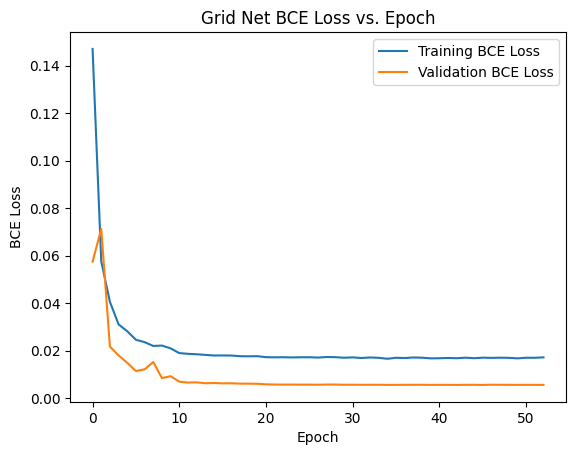

In [ ]:
# Grid-Net
gridnet = GridNet(n_channels, n_classes)
## Epochs
num_epochs = 200
## Initialize Optimizer and Learning Rate Scheduler
learning_rate = 0.001
optimizer = torch.optim.Adam(gridnet.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
## Training and tuning
loss_train_grid, loss_val_grid, best_grid = train(os.path.join(root_path, "gridnet.pth"), gridnet, loss_f, optimizer,
                                                  scheduler, num_epochs)
loss_curve(loss_train_grid, loss_val_grid, "Grid Net")

# Evaluation Metric

In [ ]:
def dice_score(pred_mask, target_mask, smooth=1e-6):
    """
    Calculate the Dice score.

    Args:
    - pred_mask (torch.Tensor): Predicted binary segmentation mask.
    - target_mask (torch.Tensor): Ground truth binary segmentation mask.
    - smooth (float, optional): Small constant to avoid division by zero (default is `1e-6`).

    Returns:
    - score (torch.Tensor): Dice score between the predicted and ground truth masks.
    """
    numerator = 2 * pred_mask * target_mask
    denominator = pred_mask * pred_mask + target_mask * target_mask
    if torch.sum(target_mask * target_mask) == 0:
        if torch.sum(pred_mask * pred_mask) == 0:
            score = 1
        else:
            score = 0
    else:
        score = (torch.sum(numerator) + smooth) / (torch.sum(denominator) + smooth)
        score = score.item()
    return score

In [ ]:
def hausdorff_distance(pred_mask, target_mask):
    """
    Calculate the normalized Hausdorff distance.

    Args:
    - pred_mask (torch.Tensor): Predicted binary segmentation mask.
    - target_mask (torch.Tensor): Ground truth binary segmentation mask.

    Returns:
    - hausdorff_dist (float): Hausdorff distance.
    """
    pred_coords = torch.nonzero(pred_mask, as_tuple=False).cpu().numpy()
    target_coords = torch.nonzero(target_mask, as_tuple=False).cpu().numpy()

    if pred_coords.size == 0 and target_coords.size == 0:
        return 0.0
    else:
        hausdorff_dist_forward = directed_hausdorff(pred_coords, target_coords)[0]
        hausdorff_dist_backward = directed_hausdorff(target_coords, pred_coords)[0]
        hausdorff_dist = max(hausdorff_dist_forward, hausdorff_dist_backward)
        return min(hausdorff_dist, np.sqrt(2 * 256 ** 2))

# Performance Evaluation

dice score & hausdorff distance

entire image and each part

In [ ]:
def evaluation(model,
               device=device,
               test_dataloader=test_dataloader):
    """
    Evaluate a segmentation model on a test dataset and compute various performance metrics.

    Args:
    - model (torch.nn.Module): The segmentation model to be evaluated.
    - device (torch.device, optional): The device on which to perform evaluation (default is `device`).
    - test_dataloader (torch.utils.data.DataLoader, optional): The DataLoader for the test dataset (default is `test_dataloader`).

    Returns:
    - (pd.DataFrame): A DataFrame containing evaluation scores for different cardiac structures.
    """
    model.eval()
    scores = {
        "lv_dice": [],
        "lv_hd": [],
        "rv_dice": [],
        "rv_hd": [],
        "myo_dice": [],
        "myo_hd": [],
        "all_dice": [],
        "all_hd": []
    }
    with torch.no_grad():
        for batch in test_dataloader:
            test_image = batch["data"]
            test_label = batch["label"]
            test_image = test_image.to(device)
            test_label = test_label.to(device)
            test_pred = model(test_image)
            pred_label = torch.argmax(test_pred, 1)

            cur_lv_dice = dice_score(test_pred[0, 3, :, :], test_label[0, 3, :, :])
            cur_lv_hd = hausdorff_distance((pred_label == 3)[0], test_label[0, 3, :, :])
            cur_rv_dice = dice_score(test_pred[0, 1, :, :], test_label[0, 1, :, :])
            cur_rv_hd = hausdorff_distance((pred_label == 1)[0], test_label[0, 1, :, :])
            cur_myo_dice = dice_score(test_pred[0, 2, :, :], test_label[0, 2, :, :])
            cur_myo_hd = hausdorff_distance((pred_label == 2)[0], test_label[0, 2, :, :])
            cur_all_dice = np.mean([cur_lv_dice, cur_rv_dice, cur_myo_dice])
            cur_all_hd = np.mean([cur_lv_hd, cur_rv_hd, cur_myo_hd])

            scores["lv_dice"].append(cur_lv_dice)
            scores["lv_hd"].append(cur_lv_hd)
            scores["rv_dice"].append(cur_rv_dice)
            scores["rv_hd"].append(cur_rv_hd)
            scores["myo_dice"].append(cur_myo_dice)
            scores["myo_hd"].append(cur_myo_hd)
            scores["all_dice"].append(cur_all_dice)
            scores["all_hd"].append(cur_all_hd)
    df = pd.DataFrame(scores)
    return df

In [ ]:
# Load model & evaluate
# ConvDeconv
conv_deconv = ConvDeconv(n_channels, n_classes).to(device)
conv_deconv.load_state_dict(torch.load(os.path.join(root_path, "convdeconv.pth")))
df_cd = evaluation(conv_deconv)
# U-Net
unet = UNET(n_channels, n_classes).to(device)
unet.load_state_dict(torch.load(os.path.join(root_path, "unet.pth")))
df_unet = evaluation(unet)
# GridNet
gridnet = GridNet(n_channels, n_classes).to(device)
gridnet.load_state_dict(torch.load(os.path.join(root_path, "gridnet.pth")))
df_gridnet = evaluation(gridnet)
# Save the result as an xlsx file
with pd.ExcelWriter(os.path.join(root_path, "network_comparison.xlsx")) as writer:
    # Write each data frame to a different sheet
    df_cd.to_excel(writer, sheet_name='Conv-Deconv', index=False)
    df_unet.to_excel(writer, sheet_name='U-Net', index=False)
    df_gridnet.to_excel(writer, sheet_name='GridNet', index=False)

In [ ]:
def visualize(image, mask):
    """
    Overlay a segmentation mask on the original image with assigned colors.

    Parameters:
    - image (numpy.ndarray): The original image.
    - mask (numpy.ndarray): Segmentation mask with channels indicating different classes.

    Returns:
    - (numpy.ndarray): The visualized image with the segmentation overlay.
    """
    original_image_rgb = np.stack((image,) * 3, axis=-1)

    # Assign colors to each channel in the segmentation result
    colors = np.array([(63, 142, 247), (252, 246, 232), (234, 101, 140)])

    # Create an empty canvas to overlay the segmentation result
    overlay = np.zeros_like(original_image_rgb)

    # Overlay each channel with the assigned color
    for i in range(3):
        overlay[mask[i + 1] == 1, :] = colors[i]
    overlay /= 255
    # Blend the original image and the overlay
    result = original_image_rgb / 4.5 + 0.15
    for i in range(256):
        for j in range(256):
            if overlay[i, j, 0] != 0:
                result[i, j, :] = result[i, j, :] * 0.1 + overlay[i, j, :] * 0.9
    return result

In [ ]:
# Visualization
current_batch = test_dataset[250]
image = current_batch["data"].unsqueeze(0).to(device)
label = current_batch["label"].unsqueeze(0).to(device)
# Get model prediction
unet.eval()
with torch.no_grad():
    pred = unet(image)
pred = torch.argmax(pred, 1)
# Convert to numpy arrays
image = image.cpu().squeeze()
label = label.cpu().squeeze()
pred = pred.cpu().squeeze()
pred_onehot = np.zeros_like(label)
for i in range(4):
    pred_onehot[i, :, :] = (pred == i)
# Plot original
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()
# Plot true label
plt.imshow(visualize(image, label))
plt.axis("off")
plt.show()
# Plot prediction result
plt.imshow(visualize(image, pred_onehot))
plt.axis('off')
plt.show()